In [1]:
import os 
from dotenv import load_dotenv
from langchain_groq.chat_models import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import MessagesState
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

In [2]:
groq_api_key = os.getenv('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model="llama-3.3-70b-versatile")

In [3]:
@tool 
def search(query: str):
    """This method will give the weather details"""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "it's cool with -10 degree"
    else:
        return "it' hot with 90 degree"

In [4]:
search.invoke("hi")

"it' hot with 90 degree"

In [5]:
tools = [search]

In [6]:
llm_with_tool = llm.bind_tools(tools)

In [7]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [8]:
response = call_model({"messages": ["hi"]})

In [9]:
messages = response['messages']

In [10]:
messages

[AIMessage(content="I'm here to help. Is there something I can help you with, or would you like to know more about the available functions, such as the 'search' function for weather details?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 213, 'total_tokens': 252, 'completion_time': 0.141818182, 'prompt_time': 0.0132784, 'queue_time': 0.04919313, 'total_time': 0.155096582}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'stop', 'logprobs': None}, id='run--8c16451d-4f31-4a68-b6e4-240e97eecfdc-0', usage_metadata={'input_tokens': 213, 'output_tokens': 39, 'total_tokens': 252})]

In [11]:
last_message = messages[-1]
last_message.tool_calls

[]

In [12]:
call_model({"messages": ["what's the weather in India?"]})

{'messages': [AIMessage(content='<function=search {"query": "India weather"} </function>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 219, 'total_tokens': 233, 'completion_time': 0.050909091, 'prompt_time': 0.014340327, 'queue_time': 0.056709279, 'total_time': 0.065249418}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_e8c9074fa2', 'finish_reason': 'stop', 'logprobs': None}, id='run--4455ad11-8fae-4987-b78b-9733d0df0e69-0', usage_metadata={'input_tokens': 219, 'output_tokens': 14, 'total_tokens': 233})]}

In [13]:
from typing import Literal

def router(state: MessagesState) -> Literal["tool", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    else:
        return END

In [14]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    router,
    {
        "tools": "tools",
        END: END
    }
)

app = workflow.compile()

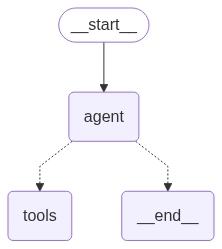

In [15]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
app.invoke({"messages": ["hi"]})

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='246684e3-96e6-48b5-ae54-bf1007c8611d'),
  AIMessage(content='Hello, how can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 213, 'total_tokens': 223, 'completion_time': 0.038344936, 'prompt_time': 0.012990493, 'queue_time': 0.049170815, 'total_time': 0.051335429}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'stop', 'logprobs': None}, id='run--c5746f29-507d-438a-9005-cbb5ae9e97a5-0', usage_metadata={'input_tokens': 213, 'output_tokens': 10, 'total_tokens': 223})]}

In [17]:
for events in app.stream({"messages": ["what the weather in sf?"]}):
    for key, value in events.items():
        print(f"Node: {key}")
        print(value)
        print("--")

Node: agent
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_spae', 'function': {'arguments': '{"query":"San Francisco weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 218, 'total_tokens': 233, 'completion_time': 0.054545455, 'prompt_time': 0.013213268, 'queue_time': 0.04973267000000001, 'total_time': 0.067758723}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cebf3f22-7e20-40cf-961e-da95a58449f9-0', tool_calls=[{'name': 'search', 'args': {'query': 'San Francisco weather'}, 'id': 'call_spae', 'type': 'tool_call'}], usage_metadata={'input_tokens': 218, 'output_tokens': 15, 'total_tokens': 233})]}
--
Node: tools
{'messages': [ToolMessage(content="it's cool with -10 degree", name='search', id='807b066a-8199-4502-b7ca-9bb2feab9ea2', tool_call_id='call_spae')]}
--


In [28]:
events = app.stream({"messages": ["what the weather in india?"]}, stream_mode="values")

In [29]:
for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what the weather in india?
================================== Ai Message ==================================
Tool Calls:
  search (call_w89j)
 Call ID: call_w89j
  Args:
    query: India weather
================================= Tool Message =================================
Name: search

it' hot with 90 degree


In [36]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "agent")
workflow.add_edge("tools", "agent")

workflow.add_conditional_edges(
    "agent",
    router,
    {
        "tools": "tools",
        END: END
    }
)

app = workflow.compile()

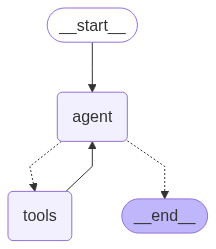

In [37]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [38]:
app.invoke({"messages": ["hi, this is sam"]})

{'messages': [HumanMessage(content='hi, this is sam', additional_kwargs={}, response_metadata={}, id='d864a648-1dbf-4833-8d95-b4a51c4bc6a9'),
  AIMessage(content="Hello Sam, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 217, 'total_tokens': 243, 'completion_time': 0.094545455, 'prompt_time': 0.013697771, 'queue_time': 0.049795037, 'total_time': 0.108243226}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run--7ddc0756-158f-41b1-99c3-4e93866634f5-0', usage_metadata={'input_tokens': 217, 'output_tokens': 26, 'total_tokens': 243})]}

In [39]:
for events in app.stream({"messages": ["who is the prime minister of rasia?"]}):
    for key, value in events.items():
        print(f"Node: {key}")
        print(value)
        print("---")

Node: agent
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xc9e', 'function': {'arguments': '{"query":"prime minister of Russia"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 441, 'total_tokens': 457, 'completion_time': 0.088098034, 'prompt_time': 0.035581832, 'queue_time': -0.087184994, 'total_time': 0.123679866}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--036a0441-0fe8-432f-bee5-e3f2645f79ec-0', tool_calls=[{'name': 'search', 'args': {'query': 'prime minister of Russia'}, 'id': 'call_xc9e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 441, 'output_tokens': 16, 'total_tokens': 457})]}
---
Node: tools
{'messages': [ToolMessage(content="it' hot with 90 degree", name='search', id='f5002f1d-4bee-4374-a7c2-b6a0db720e66', tool_call_id='call_xc9e')]}
---
Node: agent
{'messages'

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [40]:
events = app.stream({"messages": ["who is the prime minister of india?"]}, stream_mode="values")

for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

who is the prime minister of india?
================================== Ai Message ==================================
Tool Calls:
  search (call_1brt)
 Call ID: call_1brt
  Args:
    query: Prime Minister of India
================================= Tool Message =================================
Name: search

it' hot with 90 degree
================================== Ai Message ==================================
Tool Calls:
  search (call_q9w2)
 Call ID: call_q9w2
  Args:
    query: weather details for 90 degree temperature
================================= Tool Message =================================
Name: search

it' hot with 90 degree
================================== Ai Message ==================================
Tool Calls:
  search (call_4sh2)
 Call ID: call_4sh2
  Args:
    query: weather forecast for hot temperature
================================= Tool Message =================================
Nam

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

#### Adding memory

In [42]:
memory = MemorySaver()

In [43]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "agent")
workflow.add_edge("tools", "agent")

workflow.add_conditional_edges(
    "agent",
    router,
    {
        "tools": "tools",
        END: END
    }
)

app = workflow.compile(checkpointer=memory)

In [44]:
config = {"configurable": {"thread_id": "1"}}

In [45]:
events = app.stream({"messages": ["hi i am sam. An AI Engineer"]}, config=config, stream_mode="values")

In [46]:
for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

hi i am sam. An AI Engineer
================================== Ai Message ==================================

It's nice to meet you, Sam. As an AI engineer, you must be working on some interesting projects. What brings you here today? Do you have any questions or topics related to AI or weather that you'd like to discuss?


In [47]:
events = app.stream({"messages": ["who am i?"]}, config=config, stream_mode="values")

In [48]:
for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

who am i?
================================== Ai Message ==================================

You are Sam, an AI Engineer.
